# US Census Analysis (notebook 1 - statistical analysis)

### Problem Statement

*"For this technical assessment, you have been tasked with identifying characteristics that are associated with a person making more or less than $50,000 per year"*

### Overview

This notebook contains the following sections:

1. **Data preparation and cleaning**
- Map column names from metadata
- Decode numerically denoted categorical variables
- Check for NaN values
- Check for duplicates and conflicting values
- Check whether harmonization of categorical variables is necessary

2. **Exploratory data analysis**
- Descriptive statistics and distributions
- Group-level descriptive statistics
- Conditional probabilities

3. **Hypothesis testing (bivariate associations)**
- Mann-Whitney U test and Cliff's delta for numeric features
- Chi-square test and Cramer's V for categorical features

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyarrow as pa
import pyarrow.feather as feather
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

# Section 1: Data preparation and cleaning

In [ ]:
# Import train and test datasets (imported from feather files in the repository - same data as CSV but easier to store)
train = pd.read_feather('Data/Raw/census_income_learn.feather')
test = pd.read_feather('Data/Raw/census_income_test.feather')

In [3]:
# Map appropriate column names to the dataframe

colnames = [
    "age",
    "class_of_worker",
    "detailed_industry_recode",
    "detailed_occupation_recode",
    "education",
    "wage_per_hour",
    "enrolled_last_week",
    "marital_status",
    "major_industry_code",
    "major_occupation_code",
    "race",
    "hispanic_origin",
    "sex",
    "labor_union_member",
    "reason_for_unemployment",
    "employment_status",
    "capital_gains",
    "capital_losses",
    "dividends",
    "tax_filer_status",
    "region_prev_residence",
    "state_prev_residence",
    "household_family_stat",
    "household_summary",
    "instance_weight",
    "migration_msa",
    "migration_reg",
    "migration_within_reg",
    "lived_here_1yr_ago",
    "sunbelt_migration",
    "num_persons_worked_for_employer",
    "Presence_of_parents",
    "country_of_birth_father",
    "country_of_birth_mother",
    "country_of_birth_self",
    "citizenship",
    "self_employed",
    "veterans_admin_questionnaire",
    "veterans_benefits",
    "weeks_worked",
    "year",
    "income"
]

In [4]:
# Apply mapping
train.columns = colnames
test.columns = colnames

Categorical variables currently encoded as numbers
- detailed_industry_recode
- detailed_occupation_recode
- self_employed
- veterans_benefits

In [5]:
# Corresponding mapping

detailed_industry_mapping = {
    0: "Not in universe",  # <- new
    1: "Agriculture",
    2: "Forestry, fishing, hunting, trapping",
    3: "Mining",
    4: "Construction",
    5: "Nonmetallic minerals manufacturing",
    6: "Metal products manufacturing",
    7: "Machinery manufacturing",
    8: "Computer & electronics manufacturing",
    9: "Electrical equipment manufacturing",
    10: "Transportation equipment manufacturing",
    11: "Wood products manufacturing",
    12: "Furniture manufacturing",
    13: "Miscellaneous manufacturing",
    14: "Food manufacturing",
    15: "Beverage & tobacco manufacturing",
    16: "Textile, apparel & leather manufacturing",
    17: "Paper & printing",
    18: "Petroleum & coal products",
    19: "Chemical manufacturing",
    20: "Plastics & rubber manufacturing",
    21: "Wholesale trade",
    22: "Retail trade",
    23: "Transportation & warehousing",
    24: "Utilities",
    25: "Publishing (except internet)",
    26: "Film & sound recording",
    27: "Broadcasting (except internet)",
    28: "Internet publishing & broadcasting",
    29: "Telecommunications",
    30: "Internet services & data processing",
    31: "Other information services",
    32: "Finance",
    33: "Insurance",
    34: "Real estate",
    35: "Rental & leasing services",
    36: "Professional & technical services",
    37: "Company management",
    38: "Administrative & support services",
    39: "Waste management & remediation",
    40: "Education",
    41: "Hospitals",
    42: "Health care (non-hospital)",
    43: "Social assistance",
    44: "Arts, entertainment, recreation",
    45: "Accommodation",
    46: "Food services & drinking places",
    47: "Repair & maintenance",
    48: "Personal & laundry services",
    49: "Membership organisations",
    50: "Private households",
    51: "Public administration",
    52: "Armed forces"
}

detailed_occupation_mapping = {
    0:  "Not in universe",  # <- new
    1:  "Executives & Senior Managers",
    2:  "Operations, Production, HR & Agricultural Managers",
    3:  "Specialised Managers (Education, Engineering, Health, Property, Social Services)",
    4:  "Agents for Artists, Performers & Athletes",
    5:  "Business Operations Specialists",
    6:  "Accountants & Auditors",
    7:  "Financial Specialists",
    8:  "Computer Scientists, Programmers & Systems Analysts",
    9:  "Mathematicians, Statisticians & Operations Researchers",
    10: "Architects",
    11: "Surveyors & Cartographers",
    12: "Engineers & Engineering Technologists",
    13: "Physical, Life & Environmental Scientists",
    14: "Economists & Market Researchers",
    15: "Psychologists, Sociologists & Planners",
    16: "Science & Lab Technicians",
    17: "Community & Social Service Workers",
    18: "Lawyers & Judges",
    19: "Paralegals & Legal Support Workers",
    20: "Postsecondary Teachers",
    21: "School Teachers (Primary, Secondary, Special Ed)",
    22: "Librarians, Archivists & Education Support",
    23: "Arts, Design, Entertainment, Sports & Media",
    24: "Doctors, Dentists, Pharmacists & Related Practitioners",
    25: "Registered Nurses & Therapists",
    26: "Veterinarians",
    27: "Health Technicians & Diagnostic Support",
    28: "Healthcare Support (Aides, Assistants)",
    29: "Supervisors of Protective Services",
    30: "Police, Firefighters & Corrections",
    31: "Security Guards & Protective Service Workers",
    32: "Chefs & Food Service Supervisors",
    33: "Food Preparation & Serving Workers",
    34: "Housekeeping & Groundskeeping Supervisors",
    35: "Cleaners, Janitors & Pest Control",
    36: "Gaming & Personal Service Supervisors",
    37: "Personal Care, Childcare & Service Workers",
    38: "Sales Supervisors",
    39: "Sales Workers & Sales Representatives",
    40: "Office & Administrative Support",
    41: "Farming, Fishing & Forestry",
    42: "Construction Supervisors",
    43: "Carpenters",
    44: "Construction Labourers & Installers",
    45: "Electricians",
    46: "Painters, Plumbers, Roofers & Related Trades",
    47: "Extraction Workers",
    48: "Installation, Maintenance & Repair",
    49: "Production Workers",
    50: "Transport Supervisors, Pilots & Air Traffic",
    51: "Drivers, Operators & Transport Workers",
    52: "Armed Forces",
    53: "Never Worked"
}

self_employed_mapping = {
    0: "Not in universe",
    1: "Self-employed",
    2: "Not self-employed"
}

vet_benefits_map = {
    0: "Not in universe",
    1: "Receives veteran benefits",
    2: "No veteran benefits"
}

In [6]:
# Apply mapping to train and test datasets
train["detailed_industry_recode"] = train["detailed_industry_recode"].map(detailed_industry_mapping)
train["detailed_occupation_recode"] = train["detailed_occupation_recode"].map(detailed_occupation_mapping)
train["self_employed"] = train["self_employed"].map(self_employed_mapping)
train["veterans_benefits"] = train["veterans_benefits"].map(vet_benefits_map)

test["detailed_industry_recode"] = test["detailed_industry_recode"].map(detailed_industry_mapping)
test["detailed_occupation_recode"] = test["detailed_occupation_recode"].map(detailed_occupation_mapping)
test["self_employed"] = test["self_employed"].map(self_employed_mapping)
test["veterans_benefits"] = test["veterans_benefits"].map(vet_benefits_map)

In [7]:
# Merge train and test for data cleaning and EDA
full_df = pd.concat([train, test], ignore_index=True)

In [8]:
# Generate summary of dataset

summary = []

for idx in full_df.columns:
    col = full_df[idx]

    # Determine dtype category
    if pd.api.types.is_numeric_dtype(col):
        dtype = "numeric"
        col_min = col.min()
        col_max = col.max()
        uniques = col.unique()[:10]  # show first 10 unique values
    else:
        dtype = "categorical"
        col_min = None
        col_max = None
        uniques = col.unique()[:10]

    summary.append({
        "index": idx,
        "dtype": dtype,
        "min": col_min,
        "max": col_max,
        "sample_values": uniques
    })

summary_df = pd.DataFrame(summary)
summary_df

,index,dtype,min,max,sample_values
0,age,numeric,0.00,90.0,"[58, 18, 9, 10, 48, 42, 28, 47, 34, 8]"
1,class_of_worker,categorical,NaN,NaN,"[ Self-employed-not incorporated, Not in univ..."
2,detailed_industry_recode,categorical,NaN,NaN,"[Construction, Not in universe, Education, Rea..."
3,detailed_occupation_recode,categorical,NaN,NaN,"[Housekeeping & Groundskeeping Supervisors, No..."
4,education,categorical,NaN,NaN,"[ Some college but no degree, 10th grade, Ch..."
5,wage_per_hour,numeric,0.00,9999.0,"[0, 1200, 876, 500, 400, 450, 650, 475, 1100, ..."
6,enrolled_last_week,categorical,NaN,NaN,"[ Not in universe, High school, College or u..."
7,marital_status,categorical,NaN,NaN,"[ Divorced, Never married, Married-civilian ..."
8,major_industry_code,categorical,NaN,NaN,"[ Construction, Not in universe or children, ..."
9,major_occupation_code,categorical,NaN,NaN,"[ Precision production craft & repair, Not in..."


## Conduct data cleaning checks

In [9]:
# Are there any NaN values in the dataset?
full_df.isna().sum()

age                                0
class_of_worker                    0
detailed_industry_recode           0
detailed_occupation_recode         0
education                          0
wage_per_hour                      0
enrolled_last_week                 0
marital_status                     0
major_industry_code                0
major_occupation_code              0
race                               0
hispanic_origin                    0
sex                                0
labor_union_member                 0
reason_for_unemployment            0
employment_status                  0
capital_gains                      0
capital_losses                     0
dividends                          0
tax_filer_status                   0
region_prev_residence              0
state_prev_residence               0
household_family_stat              0
household_summary                  0
instance_weight                    0
migration_msa                      0
migration_reg                      0
m

In [10]:
# Look for negative income values
negative_income = full_df[full_df["wage_per_hour"] < 0]
negative_income.shape

(0, 42)

In [11]:
# Explore duplicates in the dataset (not a concern for this dataset)
duplicates = full_df[full_df.duplicated(keep=False)]

In [12]:
# Look for negative income values
negative_income = full_df[full_df["wage_per_hour"] < 0]
negative_income.shape

(0, 42)

In [13]:
# Consider whether categorical variables need to be harmonized 

cat_cols = full_df.select_dtypes(include=['object', 'category']).columns
unique_vals = {col: full_df[col].unique() for col in cat_cols}

unique_vals

for col in cat_cols:
    print(col, full_df[col].unique(), '\n')

class_of_worker [' Self-employed-not incorporated' ' Not in universe' ' Private'
 ' Local government' ' Federal government' ' Self-employed-incorporated'
 ' State government' ' Never worked' ' Without pay'] 

detailed_industry_recode ['Construction' 'Not in universe' 'Education' 'Real estate'
 'Social assistance' 'Company management' 'Utilities'
 'Waste management & remediation' 'Furniture manufacturing'
 'Rental & leasing services' 'Accommodation' 'Mining'
 'Chemical manufacturing' 'Telecommunications' 'Finance'
 'Personal & laundry services' 'Insurance' 'Transportation & warehousing'
 'Arts, entertainment, recreation' 'Professional & technical services'
 'Other information services' 'Internet services & data processing'
 'Hospitals' 'Nonmetallic minerals manufacturing'
 'Wood products manufacturing' 'Electrical equipment manufacturing'
 'Health care (non-hospital)' 'Metal products manufacturing'
 'Petroleum & coal products' 'Private households'
 'Forestry, fishing, hunting, trapping'

In [14]:
# Strip whitespace in all categorical columns
cat_cols = full_df.select_dtypes(include=['object', 'category']).columns

full_df[cat_cols] = full_df[cat_cols].apply(lambda s: s.str.strip())
train[cat_cols] = train[cat_cols].apply(lambda s: s.str.strip())
test[cat_cols] = test[cat_cols].apply(lambda s: s.str.strip())

# Replace '?' with 'Unknown'
full_df[cat_cols] = full_df[cat_cols].replace('?', 'Unknown')
train[cat_cols] = train[cat_cols].replace('?', 'Unknown')
test[cat_cols] = test[cat_cols].replace('?', 'Unknown')


In [ ]:
# # Save these three dataframes as feather files for future use
# train.to_feather('Data/Cleaned/census_income_train.feather')
# test.to_feather('Data/Cleaned/census_income_test.feather')
# full_df.to_feather('Data/Cleaned/census_income_full.feather')

# Section 2: Exploratory Data Analysis

In [16]:
# Overivew of numeric features
num_cols = [
    "age",
    "wage_per_hour",
    "weeks_worked",
    "capital_gains",
    "capital_losses",
    "dividends",
    "num_persons_worked_for_employer"
]

In [17]:
full_df[num_cols].isna().sum()
full_df[num_cols].describe()

,age,wage_per_hour,weeks_worked,capital_gains,capital_losses,dividends,num_persons_worked_for_employer
count,299283.000000,299283.000000,299283.000000,299283.000000,299283.000000,299283.000000,299283.000000
mean,34.538858,55.105395,23.178490,431.745061,36.849256,195.852568,1.956172
std,22.318431,273.341605,24.404052,4670.784009,269.790655,1937.853491,2.364859
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,0.000000,8.000000,0.000000,0.000000,0.000000,1.000000
75%,50.000000,0.000000,52.000000,0.000000,0.000000,0.000000,4.000000
max,90.000000,9999.000000,52.000000,99999.000000,4608.000000,99999.000000,6.000000


### Age

In [18]:
# Average age
average_age = full_df['age'].mean()
average_age

np.float64(34.53885787031004)

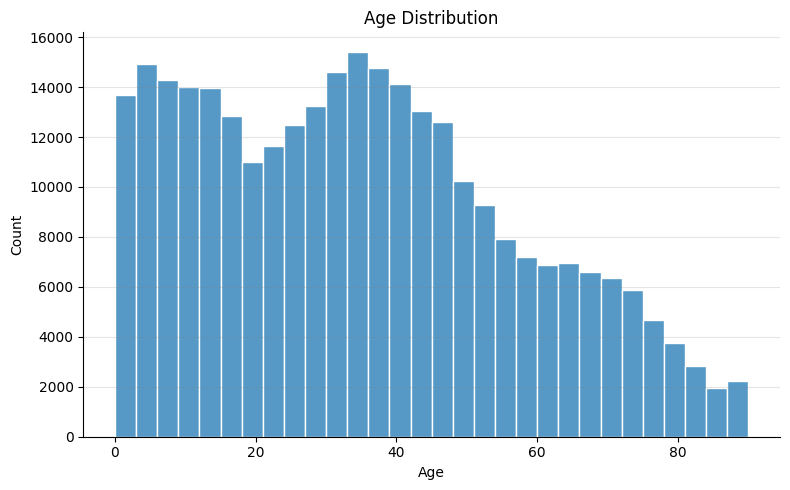

In [19]:
plt.figure(figsize=(8, 5))

sns.histplot(
    data=full_df,
    x="age",
    bins=30,
    edgecolor="white"
)

# Keep only left + bottom axes
sns.despine(top=True, right=True)

# Faint horizontal gridlines
plt.grid(axis='y', color='grey', alpha=0.2)

plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")

plt.tight_layout()
plt.show()

### Sex

In [20]:
# Derive percentage gender split
sex_counts = full_df['sex'].value_counts(normalize=True) * 100
sex_counts

sex
Female    52.04873
Male      47.95127
Name: proportion, dtype: float64

### Household composition

In [21]:
percentages = (
    full_df["household_summary"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
)

print(percentages)

household_summary
Householder                             37.90
Child under 18 never married            25.22
Spouse of householder                   20.84
Child 18 or older                        7.27
Other relative of householder            4.86
Nonrelative of householder               3.84
Group Quarters- Secondary individual     0.06
Child under 18 ever married              0.02
Name: proportion, dtype: float64


### Employment

In [22]:
counts = (
    full_df["employment_status"]
    .value_counts()
)

print(counts)

percentages = (
    full_df["employment_status"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
)

print(percentages)

employment_status
Children or Armed Forces              185459
Full-time schedules                    61202
Not in labor force                     40220
PT for non-econ reasons usually FT      5057
Unemployed full-time                    3516
PT for econ reasons usually PT          1792
Unemployed part- time                   1254
PT for econ reasons usually FT           783
Name: count, dtype: int64
employment_status
Children or Armed Forces              61.97
Full-time schedules                   20.45
Not in labor force                    13.44
PT for non-econ reasons usually FT     1.69
Unemployed full-time                   1.17
PT for econ reasons usually PT         0.60
Unemployed part- time                  0.42
PT for econ reasons usually FT         0.26
Name: proportion, dtype: float64


In [23]:
counts = (
    full_df["class_of_worker"]
    .value_counts()
)

print(counts)

percentages = (
    full_df["class_of_worker"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
)

print(percentages)

class_of_worker
Not in universe                   150323
Private                           108098
Self-employed-not incorporated     12725
Local government                   11617
State government                    6394
Self-employed-incorporated          4913
Federal government                  4330
Never worked                         643
Without pay                          240
Name: count, dtype: int64
class_of_worker
Not in universe                   50.23
Private                           36.12
Self-employed-not incorporated     4.25
Local government                   3.88
State government                   2.14
Self-employed-incorporated         1.64
Federal government                 1.45
Never worked                       0.21
Without pay                        0.08
Name: proportion, dtype: float64


### Occupation

In [24]:
percentages = (
    full_df["major_occupation_code"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
)

print(percentages)

major_occupation_code
Not in universe                          50.44
Adm support including clerical            7.38
Professional specialty                    6.95
Executive admin and managerial            6.28
Other service                             6.11
Sales                                     5.95
Precision production craft & repair       5.30
Machine operators assmblrs & inspctrs     3.20
Handlers equip cleaners etc               2.07
Transportation and material moving        2.02
Farming forestry and fishing              1.56
Technicians and related support           1.50
Protective services                       0.82
Private household services                0.40
Armed Forces                              0.02
Name: proportion, dtype: float64


I use these percentage breakdown to create bar charts and pie charts with a seperate tool for the presentation

**To generate figures here that capture the relevant distributions run the following:**

In [25]:
# # For numeric features (already defind as denum_columns earlier):

# for col in num_cols:
#     full_df[col].plot(kind='hist', title=f'Column: {col}')
#     plt.show()

In [26]:
# # For categorical features:

# # Define relevant features
# cat_cols = [
#     "class_of_worker",
#     "education",
#     "marital_status",
#     "major_occupation_code",
#     "race",
#     "sex",
#     "tax_filer_status",
#     "household_summary",
#     "citizenship_group"
# ]

# for col in cat_cols:
#     full_df[col].value_counts().plot(kind='bar', title=f'Column: {col}')
#     plt.show()

### Group-level descriptive statistics

To understand how individuals differ across income levels, I compute summary statistics separately for the two income groups (≤50k and >50k). These include average age, average weeks worked per year, and the percentage of individuals in each group with key characteristics (full-time, bachelor's degree, dividends, capital gains, etc.). I define these groups by creating new boolean columns that will allow for a cleaner more interpretable exploratory analysis.

These descriptive comparisons help answer questions such as:

**"How do dividend payments vary between high earners and lower earners?"**


### Create new boolean columns

In [27]:
income_map = {
    "- 50000.": 0,
    "50000+.": 1
}
full_df["income_binary"] = full_df["income"].map(income_map)

In [28]:
# Full-time employment?
full_df["is_full_time"] = full_df["employment_status"].eq("Full-time schedules")

# Dividends?
full_df["has_dividends"] = full_df["dividends"] > 0

# Capital gains?
full_df["has_capital_gains"] = full_df["capital_gains"] > 0

# Householder?
full_df["is_householder"] = full_df["household_summary"].eq("Householder")

In [29]:
# Education (Bachelor's degree or higher)?
bachelor_plus = [
    "Bachelors degree(BA AB BS)",
    "Masters degree(MA MS MEng MEd MSW MBA)",
    "Prof school degree (MD DDS DVM LLB JD)",
    "Doctorate degree(PhD EdD)"
]

# Education (Highschool or higher)?
highschool_plus = [
    "High school graduate",
    "Some college but no degree",
    "Associates degree-academic program",
    "Associates degree-occup /vocational",
    "Bachelors degree(BA AB BS)",
    "Masters degree(MA MS MEng MEd MSW MBA)",
    "Prof school degree (MD DDS DVM LLB JD)",
    "Doctorate degree(PhD EdD)"
]

full_df["edu_bachelor_plus"] = full_df["education"].isin(bachelor_plus)
full_df["edu_highschool_plus"] = full_df["education"].isin(highschool_plus)

In [30]:
print(full_df[["education", "edu_highschool_plus", "edu_bachelor_plus"]].head(20))

                     education  edu_highschool_plus  edu_bachelor_plus
0   Some college but no degree                 True              False
1                   10th grade                False              False
2                     Children                False              False
3                     Children                False              False
4   Some college but no degree                 True              False
5   Bachelors degree(BA AB BS)                 True               True
6         High school graduate                 True              False
7   Some college but no degree                 True              False
8   Some college but no degree                 True              False
9                     Children                False              False
10        High school graduate                 True              False
11  Some college but no degree                 True              False
12        High school graduate                 True              False
13  Ba

In [31]:
summary = (
    full_df
    .groupby("income_binary")
    .agg(
        avg_age            = ("age", "mean"),
        avg_weeks_worked   = ("weeks_worked", "mean"),
        pct_full_time      = ("is_full_time", "mean"),
        pct_bachelor_plus  = ("edu_bachelor_plus", "mean"),
        pct_highschool_plus = ("edu_highschool_plus", "mean"),
        pct_has_dividends  = ("has_dividends", "mean"),
        pct_capital_gains  = ("has_capital_gains", "mean"),
        pct_householder    = ("is_householder", "mean"),
        n_obs              = ("income_binary", "size")
    )
)

In [32]:
# Convert 0–1 proportions to 0–100 percentages
pct_cols = [
    "pct_full_time",
    "pct_bachelor_plus",
    "pct_highschool_plus",
    "pct_has_dividends",
    "pct_capital_gains",
    "pct_householder"
]

summary[pct_cols] = summary[pct_cols] * 100

# Round for readability
summary = summary.round({
    "avg_age": 2,
    "avg_weeks_worked": 2,
    **{col: 1 for col in pct_cols}
})

print(summary)

               avg_age  avg_weeks_worked  pct_full_time  pct_bachelor_plus  \
income_binary                                                                
0                33.76             21.53           18.9               11.7   
1                46.37             48.06           43.5               61.2   

               pct_highschool_plus  pct_has_dividends  pct_capital_gains  \
income_binary                                                              
0                             55.2                8.4                2.7   
1                             97.4               42.9               19.4   

               pct_householder   n_obs  
income_binary                           
0                         35.3  280715  
1                         77.9   18568  


----

### Conditional probability estimation

For any binary characteristic X, the conditional probability represents the probability of high income *among individuals who have the characteristic X*.

**Interpretation (dividends example)**

When the characteristic is **receiving dividends** (`has_dividends = 1`), the conditional probability becomes:

$$
P(\text{income} > 50000 \mid \text{has dividends} = 1)
$$

This answers questions such as:

**“Among all individuals who receive dividends, what percentage earn more than \$50,000 per year?”**

In [33]:
# Compute conditional probabilities P(>50k | attribute = TRUE)
conditional_probs = {
    "P(>50k | full_time)"          : full_df.loc[full_df["is_full_time"], "income_binary"].mean(),
    "P(>50k | bachelor_plus)"      : full_df.loc[full_df["edu_bachelor_plus"], "income_binary"].mean(),
    "P(>50k | highschool_plus)"    : full_df.loc[full_df["edu_highschool_plus"], "income_binary"].mean(),
    "P(>50k | dividends)"          : full_df.loc[full_df["has_dividends"], "income_binary"].mean(),
    "P(>50k | capital_gains)"      : full_df.loc[full_df["has_capital_gains"], "income_binary"].mean(),
    "P(>50k | householder)"        : full_df.loc[full_df["is_householder"], "income_binary"].mean()
}

# Convert to DataFrame
conditional_probs_df = (
    pd.DataFrame.from_dict(conditional_probs, orient="index", columns=["probability"])
    .sort_values("probability", ascending=False)
)

# Convert 0–1 to percentages and round
conditional_probs_df["probability"] = (conditional_probs_df["probability"] * 100).round(1)

print(conditional_probs_df)

                           probability
P(>50k | capital_gains)           32.4
P(>50k | bachelor_plus)           25.8
P(>50k | dividends)               25.2
P(>50k | full_time)               13.2
P(>50k | householder)             12.8
P(>50k | highschool_plus)         10.5


----

# Section 3: Hypothesis tests (Bivariate associations)

### Mann–Whitney U test for *numeric features*

To assess whether the distributions of `age`, `wage_per_hour` and `education` (which I ordinally encode) differ between
individuals earning ≤50k and >50k, I use the **Mann–Whitney U test**, a
nonparametric test that does not assume normality.

The test evaluates whether values in the high-income group tend to be larger or smaller
than those in the low-income group. Formally, it tests the null hypothesis:

$$
H_0: P(X_{\text{high income}} > X_{\text{low income}}) = 0.5
$$

meaning that the two groups come from the same underlying distribution.

A small p-value indicates that the distributions differ significantly, and therefore
that the variable is associated with income level. The Mann–Whitney U test is appropriate
for this dataset because:

- The income variable is binary,
- The numeric predictors are skewed (see `wage_per_hour`),
- The sample size is large,


In [34]:
# Ordinal encoding for education levels
edu_order = {
    "Less than 1st grade": 1,
    "1st 2nd 3rd or 4th grade": 2,
    "5th or 6th grade": 3,
    "7th and 8th grade": 4,
    "9th grade": 5,
    "10th grade": 6,
    "11th grade": 7,
    "12th grade no diploma": 8,
    "High school graduate": 9,
    "Some college but no degree": 10,
    "Associates degree-occup /vocational": 11,
    "Associates degree-academic program": 11,
    "Bachelors degree(BA AB BS)": 12,
    "Masters degree(MA MS MEng MEd MSW MBA)": 13,
    "Prof school degree (MD DDS DVM LLB JD)": 14,
    "Doctorate degree(PhD EdD)": 15,
    "Children": 0
}

# Create the ordinal variable
full_df["education_clean"] = full_df["education"].str.strip()
full_df["education_ordinal"] = full_df["education_clean"].map(edu_order)

In [35]:
# Define numeric columns again to include education_ordinal
num_cols = [
    "age",
    "wage_per_hour",
    "weeks_worked",
    "capital_gains",
    "capital_losses",
    "dividends",
    "num_persons_worked_for_employer",
    "education_ordinal"
]

In [36]:
mw_results = []

for col in num_cols:
    low = full_df[full_df["income_binary"] == 0][col].dropna().values
    high = full_df[full_df["income_binary"] == 1][col].dropna().values
    
    _, p = mannwhitneyu(high, low, alternative="two-sided")
    mw_results.append((col, p))

mw_df = pd.DataFrame(mw_results, columns=["variable", "mannwhitney_p"])
mw_df

,variable,mannwhitney_p
0,age,0.000000e+00
1,wage_per_hour,3.031085e-12
2,weeks_worked,0.000000e+00
3,capital_gains,0.000000e+00
4,capital_losses,0.000000e+00
5,dividends,0.000000e+00
6,num_persons_worked_for_employer,0.000000e+00
7,education_ordinal,0.000000e+00


### Cliff’s Delta to complement Mann Whitney U test for *numeric features*

**Cliff’s delta** is a nonparametric effect size that quantifies how strongly a numeric variable differs between two groups. It does not assume normality and it is well suited for skewed variables.

It is defined as:

$$\delta = P(X_{\text{high}} > X_{\text{low}}) - P(X_{\text{high}} < X_{\text{low}})$$

* **Range:** Values range from $-1$ to $1$.
* **Interpretation:** $0$ indicates no difference, while larger values indicate stronger effects.

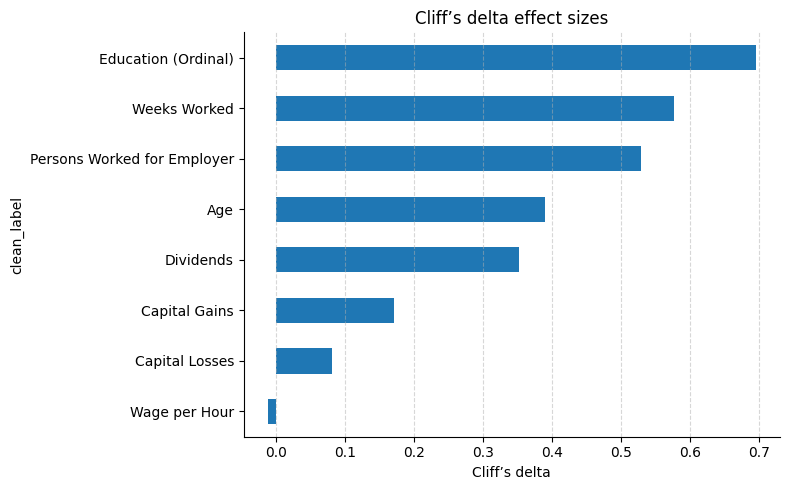

In [37]:
# Clean labels
label_map = {
    "age": "Age",
    "wage_per_hour": "Wage per Hour",
    "weeks_worked": "Weeks Worked",
    "capital_gains": "Capital Gains",
    "capital_losses": "Capital Losses",
    "dividends": "Dividends",
    "num_persons_worked_for_employer": "Persons Worked for Employer",
    "education_ordinal": "Education (Ordinal)"
}

def cliffs_delta(x, y):
    nx, ny = len(x), len(y)
    greater = np.sum(x[:, None] > y[None, :])
    smaller = np.sum(x[:, None] < y[None, :])
    return (greater - smaller) / (nx * ny)

# Compute effect sizes
rows = []
for col in num_cols:
    g0 = full_df.loc[full_df["income_binary"] == 0, col].dropna().values
    g1 = full_df.loc[full_df["income_binary"] == 1, col].dropna().values
    rows.append((col, cliffs_delta(g1, g0)))

df = pd.DataFrame(rows, columns=["variable", "delta"]).sort_values("delta")

# Apply clean labels
df["clean_label"] = df["variable"].map(label_map)
df = df.set_index("clean_label")

# Plot
plt.figure(figsize=(8, 5))
ax = df["delta"].plot(kind="barh", title="Cliff’s delta effect sizes")

plt.xlabel("Cliff’s delta")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Chi-square test of independence for *categorical variables*

For each categorical indicator, we compute a chi-square test of independence with the 
binary income variable. The test evaluates whether the characteristic is statistically 
associated with income level. With a 2×2 contingency table, the null hypothesis is:

$$
H_0: \text{The characteristic is independent of income group.}
$$


In [38]:
cat_vars = [
    "is_full_time",
    "edu_bachelor_plus",
    "edu_highschool_plus",
    "has_dividends",
    "has_capital_gains",
    "is_householder"
]

chi_results = []

for var in cat_vars:
    table = pd.crosstab(full_df[var], full_df["income_binary"])
    chi2, p, _, _ = chi2_contingency(table)
    chi_results.append((var, chi2, p))

chi_df = pd.DataFrame(chi_results, columns=["variable", "chi_square_stat", "p_value"])
chi_df

,variable,chi_square_stat,p_value
0,is_full_time,6479.044903,0.0
1,edu_bachelor_plus,34024.503828,0.0
2,edu_highschool_plus,12714.458047,0.0
3,has_dividends,21909.570475,0.0
4,has_capital_gains,13574.090066,0.0
5,is_householder,13456.954450,0.0


### Cramer's V to complement Chi Square for *categorical variables*

Cramer’s V is a nonparametric effect size used with the chi-square test to measure the strength of association between two categorical variables. It is based on the chi-square statistic and ranges from 0 to 1, where 0 indicates no association and 1 indicates a perfect association. This complements the chi-square p-value by showing how strong the relationship is, not just whether it is statistically significant. It is defined as:

$$V = \sqrt{\frac{\chi^2}{n (\min(r, k) - 1)}}$$

$\chi^2$ is the chi-square statistic.

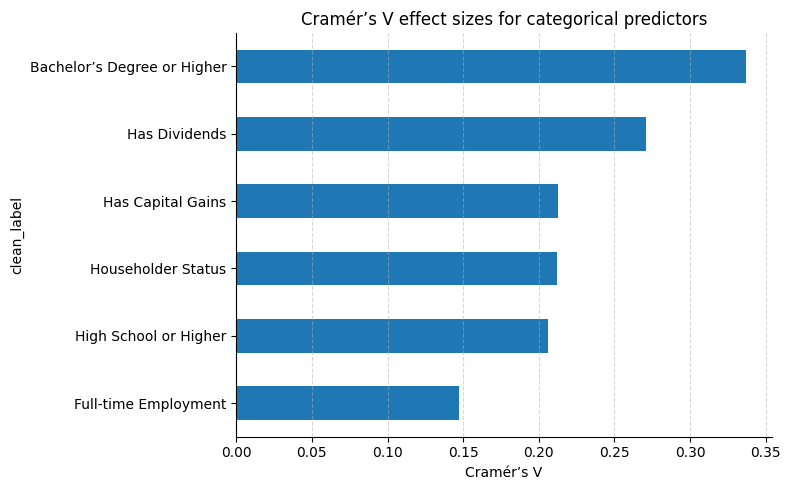

In [39]:
# Extend label_map to include your categorical variables
label_map.update({
    "is_full_time": "Full-time Employment",
    "edu_bachelor_plus": "Bachelor’s Degree or Higher",
    "edu_highschool_plus": "High School or Higher",
    "has_dividends": "Has Dividends",
    "has_capital_gains": "Has Capital Gains",
    "is_householder": "Householder Status"
})

def cramers_v(conf_matrix):
    chi2 = chi2_contingency(conf_matrix)[0]
    n = conf_matrix.sum().sum()
    r, k = conf_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

v_results = []

for var in cat_vars:
    table = pd.crosstab(full_df[var], full_df["income_binary"])
    V = cramers_v(table)
    v_results.append((var, V))

v_df = (
    pd.DataFrame(v_results, columns=["variable", "cramers_V"])
      .sort_values("cramers_V")
)

# Replace variable names with clean labels
v_df["clean_label"] = v_df["variable"].map(label_map)
v_df = v_df.set_index("clean_label")

plt.figure(figsize=(8, 5))
ax = v_df["cramers_V"].plot(
    kind="barh",
    title="Cramér’s V effect sizes for categorical predictors"
)

plt.xlabel("Cramér’s V")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

----